In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc

if not os.path.exists('NPC_result'):
    os.mkdir('NPC_result')
    
np.random.seed(14)

## load the data

In [2]:
patient = 'P9'

In [3]:
adata = sc.read_h5ad(r'E:\zhongshan\code_04_17\NMF\patient\YX487.h5ad')
adata.var_names_make_unique()
adata.obs_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells

#store the data
count_adat_fn = 'NPC_result/data_store/{}.h5ad'.format(patient)
sc.write(count_adat_fn, adata)

In [4]:
numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=2000 ## Number of over-dispersed genes to use for running the actual factorizations
#numworkers=4 # Number of parallel factorization jobs to run. Set this to a value reflective of the number of cores on your computer.
output_directory = 'NPC_result/cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = '{}_cNMF'.format(patient)

## Specify the Ks to use as a space separated list in this case "2... 6 7 8 9 10"
K = ' '.join([str(i) for i in range(2,13)])


seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'NPC_result/data_store/{}.h5ad'.format(patient)

In [5]:
prepare_cmd = 'python ./cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers 1 --seed %d --numgenes %d --beta-loss frobenius' % (output_directory, run_name, countfn, K, numiter, seed, numhvgenes)
print('Prepare command assuming no parallelization:\n%s' % prepare_cmd)
! {prepare_cmd}

Prepare command assuming no parallelization:
python ./cnmf.py prepare --output-dir NPC_result/cNMF --name P9_cNMF -c NPC_result/data_store/P9.h5ad -k 2 3 4 5 6 7 8 9 10 11 12 --n-iter 20 --total-workers 1 --seed 14 --numgenes 2000 --beta-loss frobenius


In [6]:
## Submitting all of the factorization jobs for the 0th (I.e. the only) worker
factorize_cmd = 'python ./cnmf.py factorize --output-dir %s --name %s --worker-index 0' % (output_directory, run_name)
print('Factorize command with no parallelization:\n%s' % factorize_cmd)
!{factorize_cmd}

Factorize command with no parallelization:
python ./cnmf.py factorize --output-dir NPC_result/cNMF --name P9_cNMF --worker-index 0
[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0

E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `

## Whether or not you used parallelization in the above steps, you should resume here with the combine step below which combines the individual factorization replicates so that the consensus estimate can be taken

In [7]:
cmd = 'python ./cnmf.py combine --output-dir %s --name %s' % (output_directory, run_name)
print(cmd)
!{cmd}

python ./cnmf.py combine --output-dir NPC_result/cNMF --name P9_cNMF
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.


## Compute the stability and error at each choice of K to see if a clear choice jumps out.

In [8]:
kselect_plot_cmd = 'python ./cnmf.py k_selection_plot --output-dir %s --name %s' % (output_directory, run_name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: python ./cnmf.py k_selection_plot --output-dir NPC_result/cNMF --name P9_cNMF


E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `

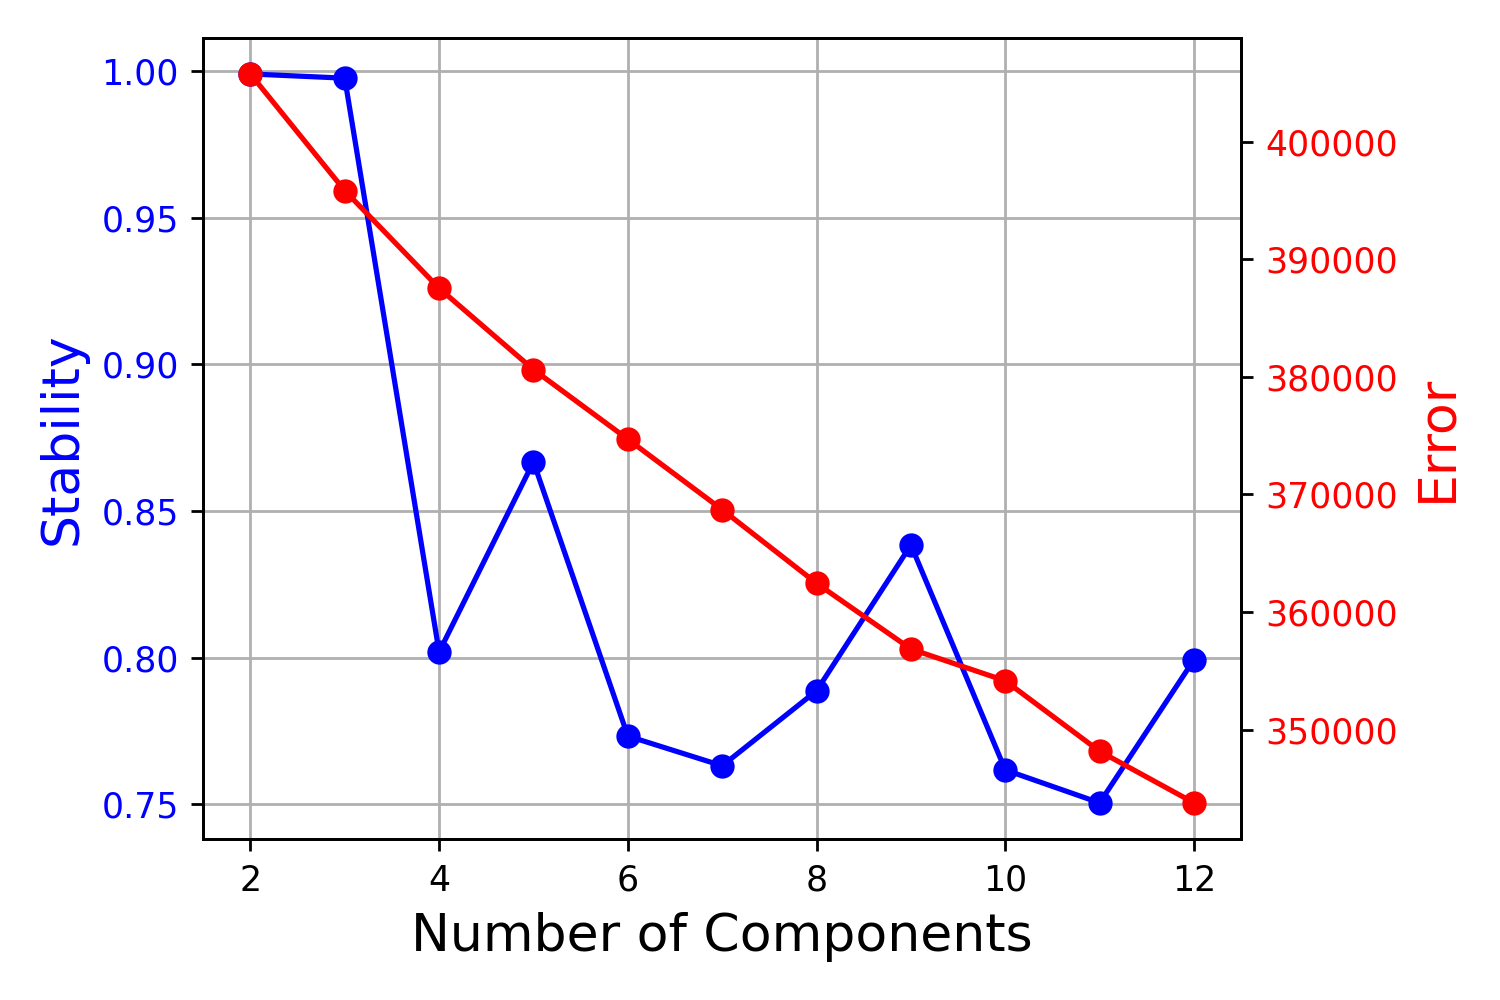

In [9]:
Image(filename = "NPC_result/cNMF/{}/{}_cNMF.k_selection.png".format(run_name, patient), width=1000, height=1000)

In [10]:
selected_K = 3
density_threshold = 2.00

In [13]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
consensus_cmd = 'python ./cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, density_threshold, selected_K)
print('Consensus command for K=3:\n%s' % consensus_cmd)
!{consensus_cmd}

Consensus command for K=3:
python ./cnmf.py consensus --output-dir NPC_result/cNMF --name P9_cNMF --local-density-threshold 2.00 --components 3 --show-clustering


E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
./cnmf.py:56: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D)
Traceback (most recen

In [14]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "NPC_result/cNMF/{}/{}_cNMF.clustering.k_%d.dt_%s.png".format(run_name, patient) % (selected_K, density_threshold_str),
      width=1000, height=1000)

FileNotFoundError: [Errno 2] No such file or directory: 'NPC_result/cNMF/P9_cNMF/P9_cNMF.clustering.k_3.dt_2_00.png'

In [15]:
density_threshold = 0.1

In [16]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
consensus_cmd = 'python ./cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, density_threshold, selected_K)
print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=3:
python ./cnmf.py consensus --output-dir NPC_result/cNMF --name P9_cNMF --local-density-threshold 0.10 --components 3 --show-clustering


E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
E:\Tools\Anaoncda\envs\cnmf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
./cnmf.py:56: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D)
Traceback (most recen

In [17]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "./NPC_result/cNMF/{}/{}_cNMF.clustering.k_%d.dt_%s.png".format(run_name, patient) % (selected_K, density_threshold_str),
      width=1000, height=1000)


FileNotFoundError: [Errno 2] No such file or directory: './NPC_result/cNMF/P9_cNMF/P9_cNMF.clustering.k_3.dt_0_10.png'

! ls ./NPC_result/cNMF/NPC_cNMF

##  Lets load in the gene_scores and identify the genes that are most associated with each program to see if we can interpret them.

In [18]:
selected_K = 3
density_threshold_str = '0_10'

In [19]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = pd.read_csv('./NPC_result/cNMF/{}/{}_cNMF.gene_spectra_score.k_%d.dt_%s.txt'.format(run_name, patient) % (selected_K, density_threshold_str),
                    sep='\t', index_col=0).T
gene_scores.head()

,1,2,3
A1BG,0.000002,-0.000104,-0.000028
A1BG-AS1,0.000052,-0.000048,-0.000013
A2ML1,-0.000190,0.000784,-0.000007
A4GALT,0.000003,0.000343,-0.000093
AAAS,0.000166,-0.000179,0.000164


In [20]:
## Obtain the top 50 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = []
ngenes = 30
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes.to_csv('./NPC_result/cNMF/{}/top_gene_30.csv'.format(run_name), index=False, header=None)

In [21]:
## Obtain the top 50 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = []
ngenes = 20
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes.to_csv('./NPC_result/cNMF/{}/top_gene_20.csv'.format(run_name), index=False, header=None)

In [22]:
## Obtain the top 50 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = []
ngenes = 50
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes.to_csv('./NPC_result/cNMF/{}/top_gene_50.csv'.format(run_name), index=False, header=None)